# **Tarea 2. Encoder-Decoder Architectures**

Guillermo Segura Gómez

### **Instrucciones**

1. Por cada ejercicio entregar un notebook con su nombre (e.g., adrian_lopez.ipynb)
2. Está prohibido compartirse código entre los estudiantes, aunque pueden comentar entre ellos las soluciones propuestas y dificultades que tengan.
3. Se pueden usar todas las funciones disponibles en PyTorch, excepto aquellas en las que explicitamente se indique en el problema.
4. Debe documentar su código con comentarios y breves discusiones de tal forma que se ve su proceso de razonamiento y facilite la evaluación para el profesor.
5. Debe proporcionar ejemplos del funcionamiento de su arquitectura. Ejemplos dónde se vea un buen resultado y otros dónde no. Deberá discutirlo brevemente y mostrar su razonamiento y criterio.
6. Muy importante: no debe usar códigos hechos por otros autores en internet. Esto será altamente penalizado.

## **Image Captioning**
Construya una arquitectura encoder-decoder para image captioning en PyTorch. El encoder debe codificar una imagen, y el decoder debe producir la descripción de la imagen. Utilice los datos de [cocodataset.org](https://cocodataset.org/#home). Por ejemplo, [val2017](http://images.cocodataset.org/zips/val2017.zip) y annotationstrainval2017.

### **1. Exploración y preprocesamiento de datos**

Comenzamos descargando los datos de **val2017** asi como sus etiquetas. Es el dataset mas pequeño, y a pesar de esto pesa 1 GB (trabajar con imágenes es costoso). Para realizar un modelo encoder-decoder pienso que la manera óptima es utilizando un modelo de red neuronal clásico con pyTorch, es decir utilizando la clase **nn.Module** ya que esta clase permite un control de la arquitectura preciso en cuando a la entrada y salida de información. Debido a que estamos trabajando con imágenes, la manera de poder extraer información de las mismas condensando en características, es utilizando operaciones de convolución y pooling en una red convolucional. Una red convolucional tiene una capa final softmax de clasificación, se puede eliminar y ya tendríamos un perfecto encoder. Para el decoder se tienen que tomar las características producidas por el encoder y utilizar tal vez una red LSTM, pero a mi me parece mejor utilizar un bloque de transformer, ya que el mecanismo de atención es mucho mejor en cuanto a la predicción. 

El dataset consiste en imágenes de diferentes cosas. Cada imagen contiene una descripción de la misma. El modelo tiene como input una imagen y como salida un texto. El modelo hará lo siguiente: 

1. Encoder: Extraer las características utilizando una red CNN
2. Decoder: Con las características el modelo genera una predicción en base a un vocabulario tokenizado formado de las descripciones de las imágenes. 

* Se ajusta el modelo en base a las descripciones tokenizadas, de esta manera el modelo aprende que son las imágenes que le vamos pasando. 

Las imágenes se tienen que leer utilizando la librería **OpenCV** para poder lograr tener nuestro vector $X$ de entrada al modelo. También tenemos que trabajar las descripciones, es necesario crear un vocabulario y además tokenizarlas para tener el vector $y$ de salida con el cual podamos entrenar. 

Se sigue cargando los datos y sus descripciones. 

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import psutil

import nltk
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
from collections import Counter
counter = Counter()
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet152, ResNet152_Weights

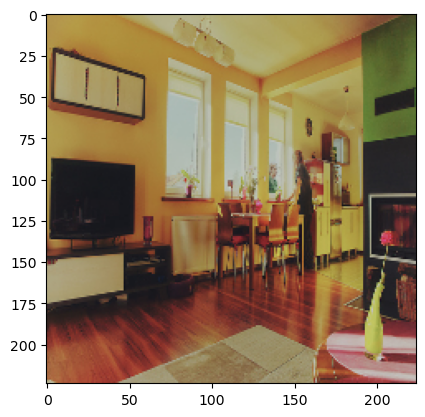

In [41]:
# Cargar una imagen
def load_image(path, target_size=(224, 224)):
    """
    Función para cargar una imagen y preprocesarla
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0 # Normalizar
    img = img.astype(np.float32)
    img = Image.fromarray((img * 255).astype(np.uint8))
    return img

# Mostrar una imagen
path_example = '/Users/guillermo_sego/Desktop/Maestría/Tercer Semestre/Transformers/data/val2017/images/000000000139.jpg'
img = load_image(path_example)
plt.imshow(img)
plt.show()

In [42]:
json_captions_train = '/Users/guillermo_sego/Desktop/Maestría/Tercer Semestre/Transformers/data/val2017/labels/captions_train2017.json'
json_captions_test = '/Users/guillermo_sego/Desktop/Maestría/Tercer Semestre/Transformers/data/val2017/labels/captions_val2017.json'

def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

data_train = load_json(json_captions_train)
data_test = load_json(json_captions_test)

data_train.keys()

dict_keys(['info', 'licenses', 'images', 'annotations'])

In [43]:
# Acceder a las anotaciones de captions
captions_train = data_train['annotations']
captions_test = data_test['annotations']

# Ejemplo: explorar la primera anotación
for i, caption in enumerate(captions_train[:5]):
    image_id = caption['image_id']
    text = caption['caption']
    print(f"Imagen ID: {image_id}, Caption: {text}")

# Cantidad de captions
print(f"\nTotal de captions: {len(captions_train)}")


Imagen ID: 203564, Caption: A bicycle replica with a clock as the front wheel.
Imagen ID: 322141, Caption: A room with blue walls and a white sink and door.
Imagen ID: 16977, Caption: A car that seems to be parked illegally behind a legally parked car
Imagen ID: 106140, Caption: A large passenger airplane flying through the air.
Imagen ID: 106140, Caption: There is a GOL plane taking off in a partly cloudy sky.

Total de captions: 591753


Primero procesamos los datos de las captions para tener el vector $y$ con el cual vamos a realizar el entrenamiento. 

In [44]:
# Creación del vocabulario
for caption in captions_train:
    text = caption['caption']
    tokens = tokenizer.tokenize(text.lower())
    counter.update(tokens)
    
# Crear el vocabulario con las palabras más frecuentes
vocab = {word: idx+4 for idx, (word, _) in enumerate(counter.most_common())}
print("Tamaño del vocabulario:", len(vocab))

Tamaño del vocabulario: 29426


In [45]:
# Añadir tokens especiales
vocab['<PAD>'] = 0  # Para rellenar secuencias cortas
vocab['<START>'] = 1  # Indica el inicio de una secuencia
vocab['<END>'] = 2  # Indica el final de una secuencia
vocab['<UNK>'] = 3  # Para palabras desconocidas

In [46]:
# Ejemplo vocabulario
print({k: vocab[k] for k in list(vocab)[:10]})

{'a': 4, '.': 5, 'on': 6, 'of': 7, 'the': 8, 'in': 9, 'with': 10, 'and': 11, 'is': 12, 'man': 13}


Para mostrar las secuencias necesitamos construir además un vocabulario invertido que tome los vectores y los convierta al vocabulario normal. 

In [47]:
# Construir el vocabulario invertido
vocab_inv = {idx: word for word, idx in vocab.items()}
print({k: vocab_inv[k] for k in list(vocab_inv)[:10]})

{4: 'a', 5: '.', 6: 'on', 7: 'of', 8: 'the', 9: 'in', 10: 'with', 11: 'and', 12: 'is', 13: 'man'}


In [48]:
def caption_to_sequence(caption, vocab):
    """
    Función para convertir una caption en una secuencia de índices.
    """

    tokens = tokenizer.tokenize(caption.lower())  # Tokenizar
    seq = [vocab.get('<START>')]  # Iniciar con el token <START>
    
    for token in tokens:
        if token in vocab:
            seq.append(vocab[token])
        else:
            # Si la palabra no está en el vocabulario, usar <UNK>
            seq.append(vocab['<UNK>'])
    
    # Añadir el token <END>
    seq.append(vocab.get('<END>'))
    return seq

def all_captions_to_sequence(captions):
    """
    Convertir todas las captions a secuencias.
    """
    sequences = []
    for caption in captions:
        text = caption['caption']
        seq = caption_to_sequence(text, vocab)
        sequences.append(seq)
    return sequences


def sequence_to_caption(sequence, vocab_inv):
    """
    Función para convertir una secuencia de índices en una caption de texto.
    """
    caption = []
    
    for idx in sequence:
        idx = int(idx)
        word = vocab_inv.get(idx, '<UNK>')  # Obtener la palabra del vocabulario invertido
        if word == '<END>':  # Detener la decodificación en el token <END>
            break
        caption.append(word)
    
    return ' '.join(caption)

In [49]:
y_train = all_captions_to_sequence(captions_train)
y_test = all_captions_to_sequence(captions_test)

In [50]:
y_train[:5]

[[1, 4, 357, 3816, 10, 4, 85, 123, 8, 42, 1084, 5, 2],
 [1, 4, 47, 10, 62, 483, 11, 4, 24, 120, 11, 296, 5, 2],
 [1, 4, 132, 29, 1465, 14, 337, 70, 8836, 144, 4, 10409, 70, 132, 2],
 [1, 4, 30, 369, 181, 88, 109, 8, 126, 5, 2],
 [1, 66, 12, 4, 16921, 195, 229, 217, 9, 4, 2202, 451, 153, 5, 2]]

Ahora necesitamos cargar los tensores donde irán las secuencias. Posteriormente en el dataloader modificamos el tamaño del batch dinámicamente con una función **collate_fn**.

In [51]:
# Crear tensores
y_train = [torch.tensor(seq) for seq in y_train]
y_test = [torch.tensor(seq) for seq in y_test]

In [52]:
len(y_train), len(y_test)

(591753, 25014)

In [53]:
# Ejemplo decodificación de una secuencia
sequence_example = y_test[0]
caption_example = sequence_to_caption(sequence_example, vocab_inv)
print("Secuencia:", sequence_example)
print("Caption:", caption_example)

Secuencia: tensor([   1,    4,   44, 5187,  129,   70,    9,   42,    7,    4,  987,    5,
           2])
Caption: <START> a black honda motorcycle parked in front of a garage .


Una vez teniendo el vocabulario y además el vector $y$, necesitamos el vector $X$ que va constar de las imágenes, sin embargo, cargar las 500 mil imágenes será muy costoso. Podemos limitar el número de imágenes cargadas con un contador. Además necesitamos una función que ordene las captions según las imágenes cargadas. 

In [54]:
def load_n_images(path, n_images):
    """
    Función para cargar n imágenes
    """
    images = []
    names = [] 
    for image in os.listdir(path):
        img = load_image(path + '/' + image) # Usamos la función implementada arriba
        images.append(img)
        names.append(image.split('.')[0])
        if len(images) == n_images:
            break
    return images, np.array(names, dtype=int)

In [55]:
def SortCaptions(captions, names, y_tensor):
    """
    Función para emparejar las imágenes con sus respectivas captions.
    Toma los nombres de las imágenes como están ordenados y ajusta el tensor de las captions
    """
    # Crear un diccionario {image_id: (caption, índice en y_tensor)}
    caption_dict = {str(caption['image_id']): (caption['caption'], idx) for idx, caption in enumerate(captions)}
    
    y_final = []
    captions_final = []
    
    # Ahora recorremos names, que corresponde a las imágenes cargadas
    for name in names:
        if str(name) in caption_dict:
            # Obtener la caption y el índice correcto en y_tensor
            caption, idx = caption_dict[str(name)]
            
            # print(caption)
            # print(idx)
            # print(y_tensor[idx])
            
            # Añadir la caption y el tensor correcto a los resultados
            y_final.append(y_tensor[idx])  # Añadir el y_tensor 
            captions_final.append(caption)  # Añadir la caption
    
    return y_final, captions_final

In [56]:
img_path_train = '/Users/guillermo_sego/Desktop/Maestría/Tercer Semestre/Transformers/data/val2017/images'
train_images_a, names = load_n_images(img_path_train, 5)

In [57]:
y_train_final, caption_final = SortCaptions(captions_test, names, y_test)

Probamos la función y vemos que coinciden los valores y las imágenes, entonces vamos por buen camino.

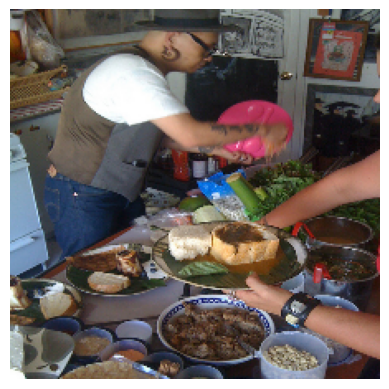

Caption: A nman with tattos picks up food from a table.



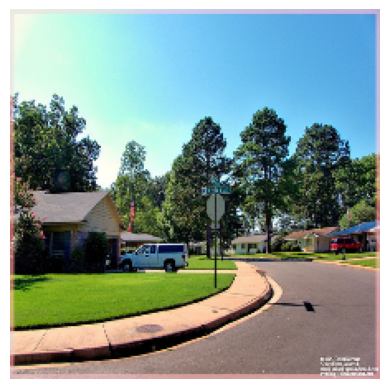

Caption: Suburban street scene showing a curve, houses, and cars in driveway.



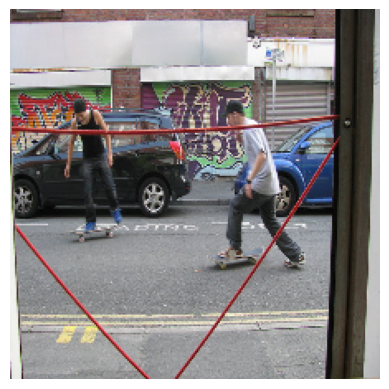

Caption: Two young men riding skateboards on a street next to a graffiti covered wall.



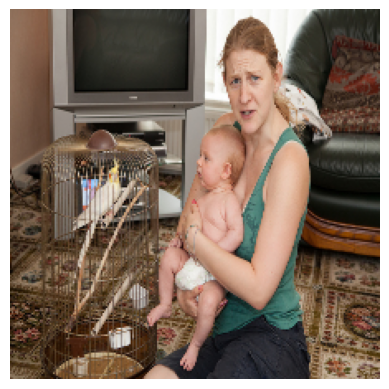

Caption: A woman holding a baby next to a caged bird.



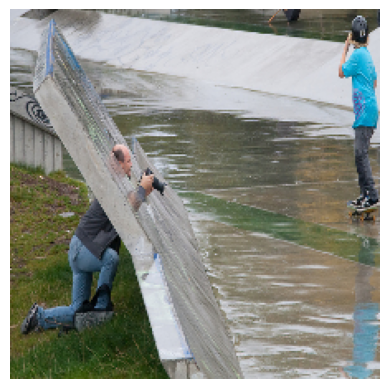

Caption: A man taking a photograph of skate boarders in the rain



In [58]:
for img, caption in zip(train_images_a, caption_final):
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Caption:", caption)
    print("")

### **Modelo**

Para construir los loaders del modelo utilizamos un dataset de pyTorch. Es importante mencionar que ahora mismo vamos a trabajar con 2000 imágenes debido al costo computacional de procesar imágenes. Esto puede repercutir en la precisión del modelo, sin embargo si el modelo optimiza y logramos buenas métricas, bastaría con aumentar el número de imágenes para obtener mejores resultados. 

In [59]:
class CocoDataset(Dataset):
    def __init__(self, images, captions, transform=None):
        self.images = images 
        self.captions = captions
        self.transform = transform 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]

        # Aplicar las transformaciones si se especificaron
        if self.transform:
            image = self.transform(image)

        return image, caption.clone().detach()

Configuramos los hiperparámetros del modelo.

In [60]:
# Hiperparámetros
_BATCH_SIZE = 10
_EMBEDDING_DIM = 256
_HIDDEN_DIM_ = 128
_NUM_EPOCHS_    = 10
_LEARNING_RATE_ = 0.001
_OUTPUT_DIM = 7
_NUM_LAYERS = 2 
_VOCAB_SIZE_ = len(vocab)
_NUM_IMAGES_ = 2000 # Por temas de memoria usamos 2 mil imágenes

In [61]:
# Cargamos las imágenes

# Al ser tantas imágenes en la misma carpeta es complicado cargarlas en test y train, de hecho tuve problemas
# puesto que todas parecían ser de test, por lo que trabajaemos con esas imágenes

# train_images, train_names = load_n_images(img_path_train, _NUM_IMAGES_)
# y_train_final, _ = SortCaptions(captions_train, train_names, y_train_padded)

In [62]:
images, names = load_n_images(img_path_train, _NUM_IMAGES_)
y_final, _ = SortCaptions(captions_test, names, y_test)

In [63]:
# Dividimos las imágenes y las etiquetas (y_final)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, y_final, test_size=0.2, random_state=42
)

print(f"Tamaño del set de entrenamiento: {len(train_images)} imágenes")
print(f"Tamaño del set de prueba: {len(test_images)} imágenes")

Tamaño del set de entrenamiento: 1600 imágenes
Tamaño del set de prueba: 400 imágenes


In [64]:
print(train_labels[0])

tensor([  1,   4,  25,  12,  28,   4, 262,  48, 255,   8, 219,   5,   2])


In [65]:
# Ver uso de memoria en megabytes
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memoria utilizada: {mem_info.rss / 1024 ** 2} MB")

# Ejemplo de uso
print_memory_usage()

Memoria utilizada: 314.265625 MB


Utilizamos una función **collate_fn** para hacer que las secuencias tengan la misma longitud. 

In [66]:
def collate_fn(batch):
    """
    Función para hacer padding dinámico dentro de cada batch.
    """
    images, captions = zip(*batch)

    # Convertir a tensores
    images = torch.stack(images, 0)

    # Hacer padding dinámico a las captions del batch
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab['<PAD>'])

    return images, captions


In [67]:
# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Convertir imagen PIL a tensor
])


# Crear el dataset, aplicando la transformación
train_dataset = CocoDataset(train_images, train_labels, transform=transform)
test_dataset = CocoDataset(test_images, test_labels, transform=transform)

# Crear el DataLoader
train_loader = DataLoader(train_dataset, 
                          batch_size=_BATCH_SIZE, 
                          shuffle=True,
                          collate_fn=collate_fn)

test_loader = DataLoader(test_dataset,
                        batch_size=_BATCH_SIZE, 
                        shuffle=False,
                        collate_fn=collate_fn)

# Verificar la carga de un lote
for batch_images, batch_captions in train_loader:
    print(f"Batch de imágenes: {batch_images.shape}")
    print(f"Batch de captions: {batch_captions.shape}")
    break

Batch de imágenes: torch.Size([10, 3, 224, 224])
Batch de captions: torch.Size([10, 18])


Ahora vamos a implementar un modelo encoder-decoder. Me parece que la mejor manera es implementar el modelo por separado, tener un encoder, un decoder y un encoder-decoder. El encoder va extraer las características de las imágenes. El decoder va utilizar ese espacio de características para generar un texto. El texto generado va estar codificado en un vocabulario que previamente construimos. Luego entrenamos el modelo con los conjuntos que ya tenemos y tenemos el modelo final. 

In [68]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        
        resnet = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
        
        # Quitar la última capa fully connected
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        
        # Agregar capa fully connected con ReLU y Dropout
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, images):
        # Extraer características con ResNet
        with torch.no_grad():
            features = self.resnet(images)

        # Aplanar la salida
        features = features.view(features.size(0), -1)

        # Pasar por la capa lineal, ReLU y Dropout
        features = self.fc(features)
        features = self.relu(features)
        features = self.dropout(features)

        return features

In [69]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_size)  # Capa de embedding para las palabras
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)  # Capa fully connected para predecir la siguiente palabra
        self.hidden_size = hidden_size
        
    def forward(self, features, captions):
        # Eliminar el token <END> de las captions para entrenar el LSTM
        embeddings = self.embed(captions[:, :-1]) 
        # Concatenar las características de la imagen con los embeddings
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        lstm_out, _ = self.lstm(inputs)  # Pasar por el LSTM
        outputs = self.linear(lstm_out)  # Predecir la siguiente palabra
        return outputs

Al momento de realizar la inferencia en el test necesitamos una función sample para generar las muestras, la implementamos en la clase madre de encoder-decoder. 

In [70]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(EncoderDecoder, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
        
    def forward(self, images, captions=None, max_len=20):
        # Extraer características de la imagen
        features = self.encoder(images)
        
        # Si se pasan captions (entrenamiento), las usa para predecir
        if captions is not None:
            outputs = self.decoder(features, captions)
        else:
            # Si no se pasan captions (inferencia), generar la secuencia
            outputs = self.sample(features, max_len)

        return outputs
    
    def sample(self, features, max_len=20):
        """
        Método de generación de captions a partir de características de imagen.
        """
        sampled_ids = []
        inputs = features.unsqueeze(1)  
        states = None
        for _ in range(max_len):
            hiddens, states = self.decoder.lstm(inputs, states)  
            outputs = self.decoder.linear(hiddens.squeeze(1))  
            _, predicted = outputs.max(1) 
            sampled_ids.append(predicted.item())  

            inputs = self.decoder.embed(predicted)  
            inputs = inputs.unsqueeze(1)  

        return sampled_ids

In [71]:
# Definimos el dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("El dispositivo es:", device)

El dispositivo es: mps


In [72]:
# Definir el modelo
model = EncoderDecoder(embed_size=_EMBEDDING_DIM, 
                       hidden_size=_HIDDEN_DIM_, 
                       vocab_size=_VOCAB_SIZE_, 
                       num_layers=_NUM_LAYERS).to(device)

In [73]:
print(model)

EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [74]:
# Definir el optimizador y la función de pérdida
params = list(model.decoder.parameters()) + list(model.encoder.fc.parameters())
optimizer = torch.optim.Adam(params, lr=_LEARNING_RATE_)
criterion = nn.CrossEntropyLoss()

log_interval = 50

In [75]:
def calculate_bleu(reference_captions, predicted_caption):
    """
    Calcula el BLEU score para una caption generada y la referencia.
    """
    smoothie = SmoothingFunction().method4 
    return sentence_bleu([reference_captions], predicted_caption, smoothing_function=smoothie)

In [76]:
# Ciclo de entrenamiento modificado
for epoch in range(_NUM_EPOCHS_):
    model.train()
    total_loss = 0
    total_bleu = 0  # Para llevar el registro de BLEU score
    total_samples = 0  # Para contar el número de muestras procesadas

    for batch_idx, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Pasar los datos al dispositivo
        features = features.float().to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(features, labels)
        loss = criterion(outputs.view(-1, _VOCAB_SIZE_), labels.view(-1))
        loss.backward()
        optimizer.step()

        # Sumar la pérdida del lote actual
        total_loss += loss.item()

        # Evaluar BLEU para cada predicción del lote
        for i in range(labels.size(0)):
            # Obtener la caption de referencia
            reference_sequence = labels[i].cpu().numpy()  
            reference_caption = sequence_to_caption(reference_sequence, vocab_inv)

            # Obtener la caption generada
            predicted_sequence = outputs[i].argmax(1).cpu().numpy() 
            predicted_caption = sequence_to_caption(predicted_sequence, vocab_inv)

            # Calcular BLEU score
            bleu = calculate_bleu(reference_caption, predicted_caption)
            total_bleu += bleu
            total_samples += 1

            # Mostrar la imagen con las captions cada log_interval
            # if i == 0 and batch_idx % log_interval == 0:  # Mostrar solo una imagen por batch
            #     # Mostrar las captions
            #     print(f"Referencia: {reference_caption}")
            #     print(f"Predicción: {predicted_caption}")
            #     print(f"BLEU: {bleu:.4f}")
            #     print("")

            #     # Mostrar la imagen
            #     img = features[i].permute(1, 2, 0).cpu().numpy()
            #     plt.imshow(img)
            #     plt.axis('off')
            #     plt.show()
        

        # Imprimir cada `log_interval` iteraciones
        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, BLEU: {total_bleu / total_samples:.4f}")

    # Calcular la pérdida y el BLEU score promedio para la epoch completa
    avg_loss = total_loss / len(train_loader)
    avg_bleu = total_bleu / total_samples

    # Imprimir al final de cada epoch
    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Avg BLEU: {avg_bleu:.4f}")

Epoch 1, Batch 0, Loss: 10.3056, BLEU: 0.0771
Epoch 1, Batch 50, Loss: 3.1460, BLEU: 0.0467
Epoch 1, Batch 100, Loss: 4.0495, BLEU: 0.0922
Epoch 1, Batch 150, Loss: 4.0771, BLEU: 0.1006
Epoch 1 completed, Avg Loss: 4.9006, Avg BLEU: 0.1026
Epoch 2, Batch 0, Loss: 3.8372, BLEU: 0.1434
Epoch 2, Batch 50, Loss: 3.1827, BLEU: 0.1431
Epoch 2, Batch 100, Loss: 2.9052, BLEU: 0.1455
Epoch 2, Batch 150, Loss: 3.6563, BLEU: 0.1527
Epoch 2 completed, Avg Loss: 3.4433, Avg BLEU: 0.1550
Epoch 3, Batch 0, Loss: 2.6969, BLEU: 0.1636
Epoch 3, Batch 50, Loss: 3.6131, BLEU: 0.1980
Epoch 3, Batch 100, Loss: 2.5795, BLEU: 0.2052
Epoch 3, Batch 150, Loss: 3.3246, BLEU: 0.2079
Epoch 3 completed, Avg Loss: 3.2067, Avg BLEU: 0.2099
Epoch 4, Batch 0, Loss: 2.9848, BLEU: 0.2752
Epoch 4, Batch 50, Loss: 3.3569, BLEU: 0.2251
Epoch 4, Batch 100, Loss: 3.4104, BLEU: 0.2302
Epoch 4, Batch 150, Loss: 3.2239, BLEU: 0.2377
Epoch 4 completed, Avg Loss: 3.0294, Avg BLEU: 0.2371
Epoch 5, Batch 0, Loss: 3.1966, BLEU: 0.240

Ahora necesitamos probar el modelo.

In [77]:
def generate_caption(model, image, vocab_inv):
    """
    Genera una caption para una imagen usando el modelo entrenado.
    """
    model.eval()  
    with torch.no_grad():
        # Pasar la imagen al dispositivo
        image = image.unsqueeze(0).float().to(device)  # Añadir dimensión batch
        
        # Forward pass a través del modelo (sin labels)
        outputs = model(image, None)  
        predicted_sequence = outputs  

        # Convertir los índices de palabras a texto
        predicted_caption = sequence_to_caption(predicted_sequence, vocab_inv)

    return predicted_caption

def test_model(model, test_loader, vocab_inv, num_images=5, max_len=20):
    """
    Probar el modelo y mostrar imágenes con captions generadas y de referencia.
    """
    model.eval()  # Poner el modelo en modo evaluación
    batch = next(iter(test_loader))  # Tomar un batch de imágenes de prueba

    images, captions = batch  # Obtener las imágenes y captions del lote

    # Probar en las primeras `num_images` imágenes del lote
    for i in range(num_images):
        image = images[i]
        
        # Obtener la caption de referencia
        reference_sequence = captions[i].cpu().numpy()  
        reference_caption = sequence_to_caption(reference_sequence, vocab_inv)
        
        # Generar la caption con el modelo
        predicted_caption = generate_caption(model, image, vocab_inv)

        # Calcular BLEU (si tienes una función `calculate_bleu`)
        bleu = calculate_bleu(reference_caption, predicted_caption)

        # Mostrar los resultados
        print(f"Referencia: {reference_caption}")
        print(f"Predicción: {predicted_caption}")
        print(f"BLEU: {bleu:.4f}")
        print("")

        # Mostrar la imagen
        img = image.permute(1, 2, 0).cpu().numpy()  # Cambiar formato de (C, H, W) a (H, W, C)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

Referencia: <START> a house is sitting on an empty block
Predicción: <START> a man is sitting on a table with a white room .
BLEU: 0.4945



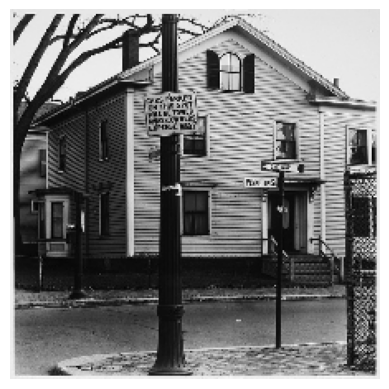

Referencia: <START> a person hugging another while cutting a cake .
Predicción: <START> a man is sitting on a table with a white room .
BLEU: 0.4024



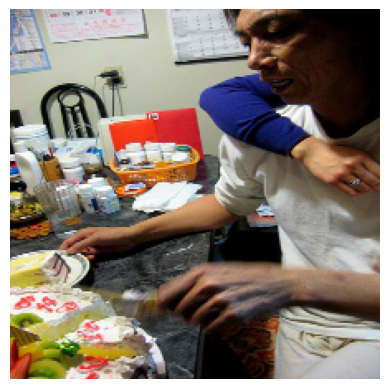

Referencia: <START> some cattle are walking on a dirt trail
Predicción: <START> a man is sitting on a table with a white room .
BLEU: 0.3706



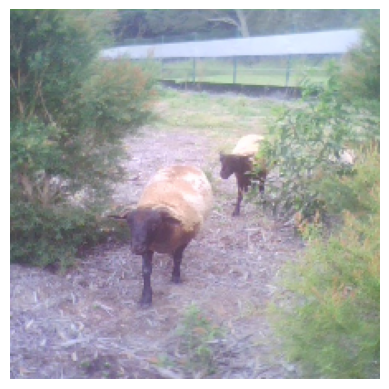

Referencia: <START> a man riding a surfboard on a wave in the ocean .
Predicción: <START> a man is sitting on a table with a white room .
BLEU: 0.4671



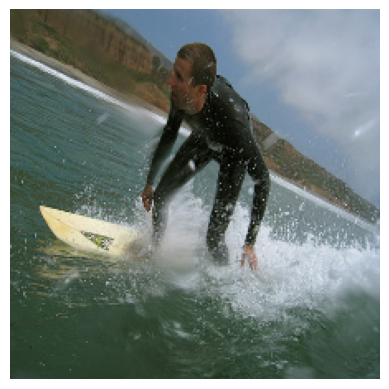

Referencia: <START> a row of motorcycles parked on the side of a road .
Predicción: <START> a man is sitting on a table with a white room .
BLEU: 0.3153



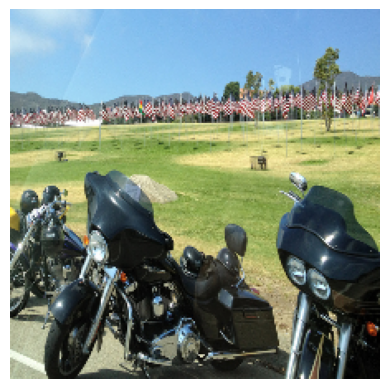

In [78]:
# Probamos el modelo
test_model(model, test_loader, vocab_inv, num_images=5)